# Developing Pyhon Raster Functions - Pixel Blocks and Metadata
This notebook serves as a tutorial on how to use the exported ```pixel_blocks``` and ```metadata``` to create a Python Raster Function.

## Imports

We use ```os``` and ```pickle``` to get the data. We will be working with numerical arrays with ```numpy``` and date objects with ```datetime```.

In [1]:
import numpy as np
import datetime
import os
import pickle

## Debug Logs

We are sending debug logs into the debug logs folder.

In [2]:
debug_logs_directory = r'C:\PROJECTS\SFA\debug'

# Examining the Pixel Block Data Structure

I will read in the ```pixel_blocks```. This allows me to understand the structure of the pixel blocks and will facilitate algorithm development.

In [3]:
filename = 'updatePixels_2019_Dec_18_08_54_26pix_blocks.p'
pickle_file = os.path.join(debug_logs_directory, filename)
pix_blocks = pickle.load(open(pickle_file,"rb"))
print(type(pix_blocks))
print(pix_blocks)

<class 'tuple'>
(array([[[ 776,  732,  822, ...,  210,  193,  287],
        [ 775,  787,  862, ...,  180,  200,  165],
        [ 597,  715,  819, ...,  183,  189,  194],
        ...,
        [ 237,  337,  368, ...,  146,  146,  117],
        [ 197,  300,  303, ...,  174,  171,  142],
        [ 179,  215,  202, ...,  224,  219,  161]],

       [[1026,  978, 1124, ...,  355,  351,  471],
        [1061, 1105, 1187, ...,  335,  380,  343],
        [ 861,  971, 1078, ...,  339,  345,  377],
        ...,
        [ 412,  561,  572, ...,  280,  277,  281],
        [ 354,  527,  509, ...,  322,  320,  294],
        [ 368,  413,  430, ...,  428,  407,  315]],

       [[1226, 1228, 1417, ...,  317,  302,  552],
        [1264, 1419, 1472, ...,  273,  300,  283],
        [1018, 1178, 1323, ...,  268,  252,  355],
        ...,
        [ 340,  493,  615, ...,  161,  169,  157],
        [ 247,  411,  425, ...,  217,  232,  191],
        [ 211,  261,  272, ...,  334,  315,  234]],

       ...,

       

# Casting to a numpy array

TJe ```pix_blocks``` object is a tuple that holds a numpy array (I don't know why Esri does this). I will recast it to a numpy array and then I can see this is actually a 4-dimmentional array.

In [4]:
pix_array = np.asarray(pix_blocks)
print(type(pix_array))
print("Shape: " + str(pix_array.shape))

<class 'numpy.ndarray'>
Shape: (3, 13, 108, 208)


# Viewing the bands

I will use ```matplotlib``` to visualize the bands. Here I loop over all the bands in the timestemp.

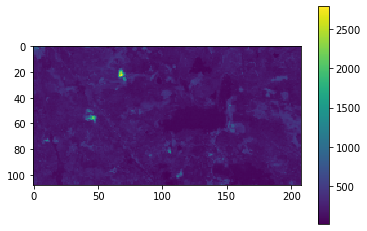

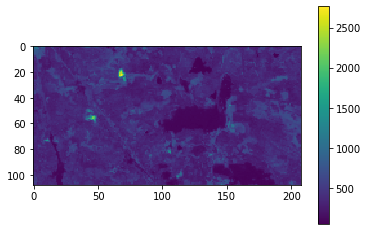

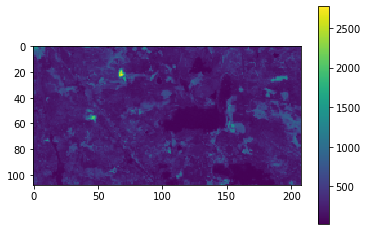

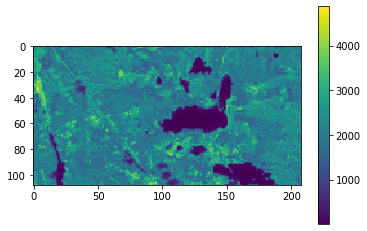

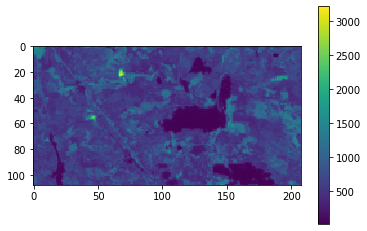

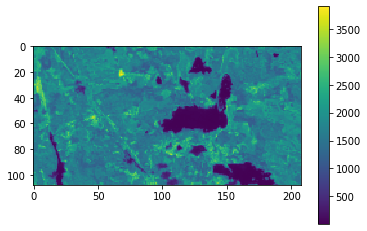

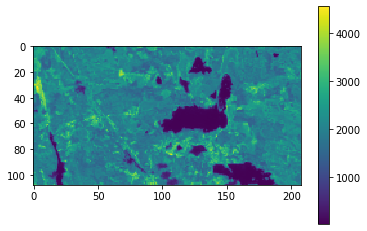

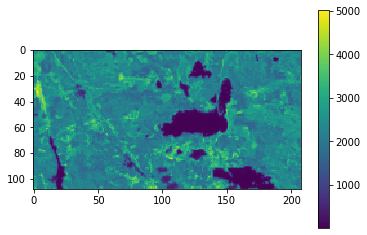

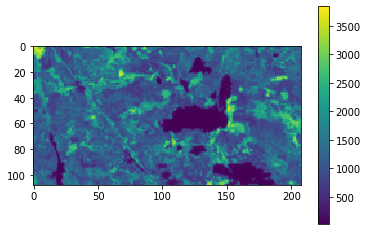

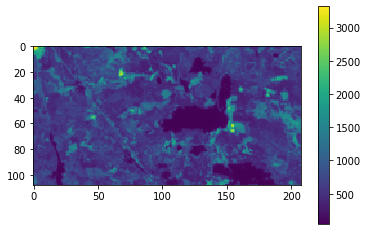

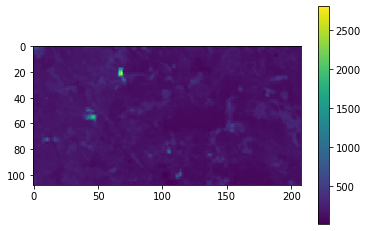

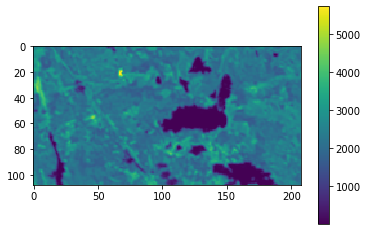

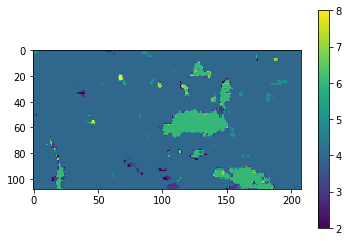

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt  

for i in range(13):
    plt.imshow(pix_array[0,i,:,:])
    plt.colorbar()
    plt.show()

# Examining the Metadata Structure

I will read in the metadata structure to examine how metadata is strutured within a Python Raster Function

In [7]:
time_filename = 'updatePixels_2019_Dec_18_08_54_26metadata.p'
pickle_file = os.path.join(debug_logs_directory, time_filename)
metadata = pickle.load(open(pickle_file,"rb"))
metadata

({'acquisitiondate': 43305.437771550925, 'instrument': 'MSI', 'level': 'L2A'},
 {'acquisitiondate': 43297.43080398148, 'instrument': 'MSI', 'level': 'L2A'},
 {'acquisitiondate': 43302.43083866898, 'instrument': 'MSI', 'level': 'L2A'})

# Metadata dictionary

The metadata is structured as a dictionary and the indices should line up with the indices of the pixel blocks.

In [8]:
metadata[0]

{'acquisitiondate': 43305.437771550925, 'instrument': 'MSI', 'level': 'L2A'}

In [9]:
metadata[0]['acquisitiondate']

43305.437771550925

# Developing the algorithm

Now that we see what data get pulled into a raster function, the algorithm can be developed.

## User Inputs

We define teh user inputs:
- start_day
- start_year
- end_day
- end_year
- pixel_percentile

In [10]:
start_day = 120
start_year = 2015
end_day = 300
end_year = 2030
pixel_percentile = 50

# Parsing the ```acquisitiondate```

In [11]:
t_vals = [j['acquisitiondate'] for j in metadata]
print(t_vals)

[43305.437771550925, 43297.43080398148, 43302.43083866898]


# Turning dates into array of years and days since January 1


In [12]:
base_date = datetime.datetime(1900, 1, 1) - datetime.timedelta(days=2)
year_doy = np.zeros((len(t_vals), 2))
year_doy[:, 0] = [(base_date + datetime.timedelta(days=t)).year for t in t_vals]
year_doy[:, 1] = [(base_date + datetime.timedelta(days=t)).timetuple().tm_yday for t in t_vals]
print(year_doy)

[[2018.  205.]
 [2018.  197.]
 [2018.  202.]]


# Filter the pixels and acquisition date on the inputs values 

In [13]:
filtered_year_doy = [[idx, ym] for idx, ym in enumerate(year_doy) if
                     ((ym[0] >= start_year and ym[0] <= end_year) and (
                             ym[1] >= start_day and ym[1] <= end_day))]

year_doy_filtered_indices = [idx[0] for idx in filtered_year_doy]
pix_array_filtered = pix_array[year_doy_filtered_indices, :, :, :]

pix_array_dim = pix_array_filtered.shape
num_bands = pix_array_dim[1] - 1
num_squares_x = pix_array_dim[2]
num_squares_y = pix_array_dim[3]
print(pix_array_dim)

(3, 13, 108, 208)


# Defining a function to mask out bad pixels

I define an ```apply_mask``` function that will flag all bad pixel values.

In [14]:
SENTINEL_2_CLEAR_PIX_VALS = [4, 5, 6, 7, 11]
FILTER_VAL = -3001
QA_BAND_NUM = 13

def apply_mask(tct_stack, bqa_stack, clear_code):
    tct_stack[~np.isin(bqa_stack, clear_code)] = FILTER_VAL
    return tct_stack.astype('float')

Here, I apply the mask

In [15]:
# QA band index
qa_band_ind = QA_BAND_NUM - 1

# Defining the QA band as its own array
bqa_stack = pix_array_filtered[:, qa_band_ind, :, :]

# Removing the QA band from the ixel band
pix_array_filtered = pix_array_filtered[:, 0:qa_band_ind, :, :]

# Expand the dimmensions of the array to match the inputs
bqa_stack = np.expand_dims(bqa_stack, 1)

# Repreat the bqa array so that it applies to app bands
bqa_stack = np.repeat(bqa_stack, qa_band_ind, 1)

# Apply the filter function
pix_array_filtered = apply_mask(pix_array_filtered,
                                bqa_stack,
                                SENTINEL_2_CLEAR_PIX_VALS)

I would generally use **masked arrays** for this calculation with numpy,bute **masked arrays** don't support *NaNs*. So, I convert all the flagged values to ```NaN``` and thenI will uses ```numpy.nanpercentile``` for the calculation. 

In [16]:
masked_pix_array = np.ma.masked_where(pix_array_filtered == FILTER_VAL, pix_array_filtered)
mdata = np.ma.filled(masked_pix_array, np.nan)

Here I use ```nanpercentile``` for the calculation and use the time magic to time how long it takes to execute.

In [17]:
%%time

percentile_raster = np.nanpercentile(mdata,
                              pixel_percentile,
                              axis=0)


Wall time: 17.2 s


# Reviewing the Results

First, let's look at the dimensions of the result. There should be 12 bands.

In [18]:
percentile_raster.shape

(12, 108, 208)

We can also plot the results. This is nice, but sometimes it's not too helpful.

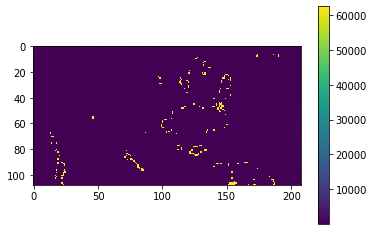

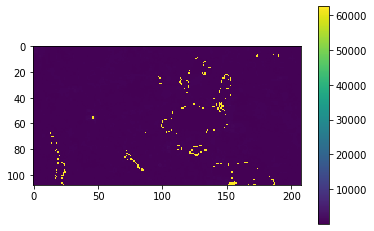

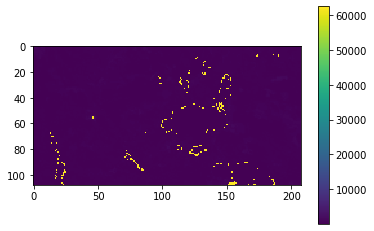

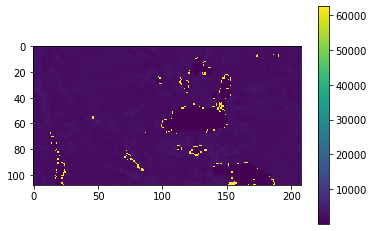

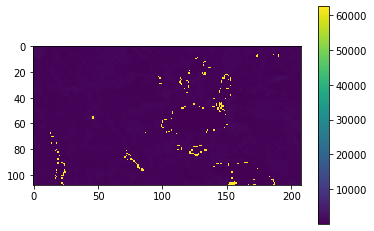

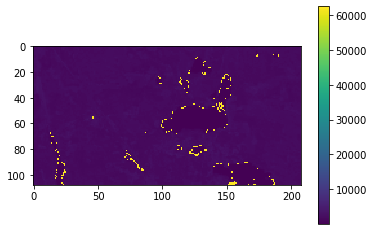

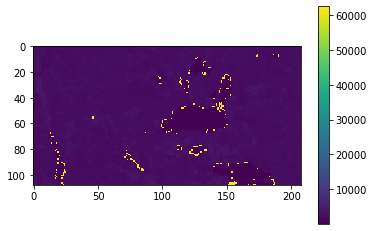

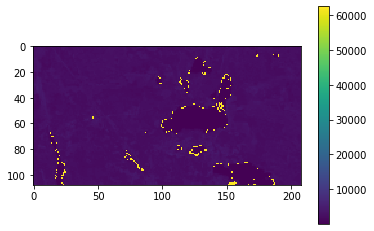

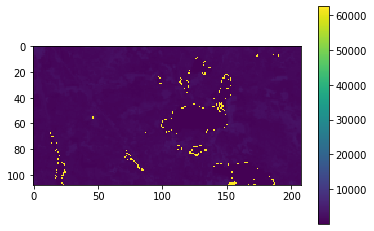

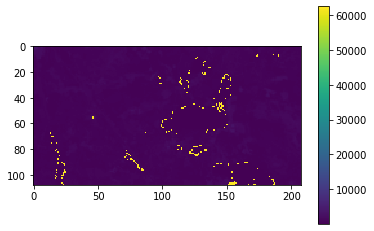

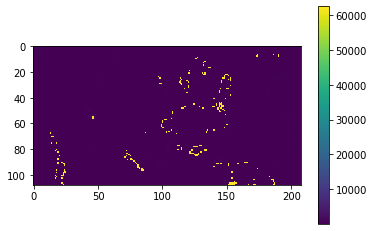

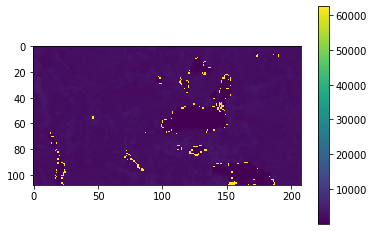

In [19]:
for i in range(12):
    plt.imshow(percentile_raster[i,:,:])
    plt.colorbar()
    plt.show()

What is most helpful is probably picking a pixel, doing the calculation, and comparing it to the result. Here, we will take a random ```x,y``` location and verify the results.

In [24]:
x,y = (2,2)

The array at that location is:

In [25]:
pix_array[:,0,x,y]

array([819, 870, 867], dtype=uint16)

The result at that location is

In [26]:
percentile_raster[0,x,y]

867.0

Do we get the same value of we do the calculation?

In [27]:
np.percentile(pix_array[:,0,x,y], 50)

867.0